In [235]:
import torchvision
import torch
import torch.nn.functional as F
import numpy as np
import json
import utils as ut

In [226]:
# training set
train_data = torchvision.datasets.FashionMNIST('./data', train = True, download = True,
transform = torchvision.transforms.ToTensor())
# test set
test_data = torchvision.datasets.FashionMNIST('./data', train = False,
transform = torchvision.transforms.ToTensor())

In [227]:
# Determine the number of samples per class for the split
samples_per_class = 6000  
num_classes = 10 
val_samples_per_class = int(samples_per_class * 0.1)  # 10% for validation

# Prepare indices for splitting
indices = np.arange(len(train_data))
targets = np.array(train_data.targets)

train_indices = []
val_indices = []

for i in range(num_classes):
    class_indices = indices[targets == i]
    np.random.shuffle(class_indices)  # Shuffle indices to ensure random split
    val_indices.extend(class_indices[:val_samples_per_class])
    train_indices.extend(class_indices[val_samples_per_class:])

# Convert to PyTorch tensors
train_indices = torch.tensor(train_indices)
val_indices = torch.tensor(val_indices)

# Create subset datasets
train_subset = torch.utils.data.Subset(train_data, train_indices)
val_subset = torch.utils.data.Subset(train_data, val_indices)

# Create DataLoaders
train_generator = torch.utils.data.DataLoader(train_subset, batch_size=50, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_subset, batch_size=50, shuffle=False)
test_generator = torch.utils.data.DataLoader(test_data, batch_size = 50, shuffle = False)


In [228]:
def train_model(model, train_loader, val_loader, epochs=15, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, train_acc, val_acc = [], [], []
    
    for epoch in range(1,epochs+1,1):
        model.train()  # Set model to training mode
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = F.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 10 == 0:  # Record every 10 steps
                train_loss.append(loss.item())
                train_accuracy = 100 * correct / total
                train_acc.append(train_accuracy)  
                val_accuracy = validate_model(model_mlp, val_generator)
                val_acc.append(val_accuracy)
                
                print("Epoch: {0:2d}/{1:2d}    Loss: {2:2.4f}    Train Acc: {3:2.4f}   Val Acc:{4:2.4f}".format(epoch,epochs,loss,train_accuracy,val_accuracy))

    first_layer_weights = model_mlp.fc1.weight.data.cpu().numpy()
    return first_layer_weights,train_acc,val_acc,train_loss


def validate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [229]:

class mlp_1(torch.nn.Module):
    def __init__(self, input_size):
        super(mlp_1, self).__init__()
        self.input_size = input_size
        # Adjust the hidden layer size to 32
        self.fc1 = torch.nn.Linear(input_size, 32)  # FC-32
        self.relu = torch.nn.ReLU()  # ReLU activation
        self.fc2 = torch.nn.Linear(32, 10)  # Prediction layer, size = num_classes

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input if needed
        hidden = self.fc1(x)  # Pass through the first fully connected layer
        relu = self.relu(hidden)  # Apply ReLU activation
        output = self.fc2(relu)  # Pass through the prediction layer
        return output

model_mlp = mlp_1(784)

In [230]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mlp.parameters(), lr = 0.01, momentum = 0.0)

In [231]:
first_layer_weights,train_acc,val_acc,train_loss = train_model(model_mlp,train_generator,val_generator)

Epoch:  1/15    Loss: 2.3526    Train Acc: 6.0000   Val Acc:33.1000
Epoch:  1/15    Loss: 0.9997    Train Acc: 45.6364   Val Acc:62.5667
Epoch:  1/15    Loss: 0.7040    Train Acc: 56.2857   Val Acc:64.0833
Epoch:  1/15    Loss: 0.6740    Train Acc: 60.3871   Val Acc:70.7500
Epoch:  1/15    Loss: 0.7387    Train Acc: 63.5122   Val Acc:71.6167
Epoch:  1/15    Loss: 0.5907    Train Acc: 65.4118   Val Acc:72.7667
Epoch:  1/15    Loss: 0.5353    Train Acc: 66.8197   Val Acc:74.7833
Epoch:  1/15    Loss: 0.6040    Train Acc: 68.0000   Val Acc:76.6833
Epoch:  1/15    Loss: 0.6459    Train Acc: 68.7654   Val Acc:76.4833
Epoch:  1/15    Loss: 0.3367    Train Acc: 69.5824   Val Acc:78.0667
Epoch:  1/15    Loss: 0.7026    Train Acc: 70.4554   Val Acc:79.0500
Epoch:  1/15    Loss: 0.4726    Train Acc: 71.2252   Val Acc:77.7833
Epoch:  1/15    Loss: 0.4398    Train Acc: 72.0661   Val Acc:75.3833
Epoch:  1/15    Loss: 0.6010    Train Acc: 72.0916   Val Acc:77.4333
Epoch:  1/15    Loss: 0.6683    Tra

In [232]:
test_accuracy = validate_model(model_mlp,test_generator)
print(test_accuracy)

85.74


In [238]:
# Form the dictionary
architecture_name = "mlp_1"

experiment_results = {
    'name': architecture_name,
    'loss_curve': train_loss,
    'train_acc_curve': train_acc,
    'val_acc_curve': val_acc,
    'test_acc': test_accuracy,
    'weights': first_layer_weights.tolist()
}

# Save the dictionary to a file
filename = f"part3_{architecture_name}.json"
with open(filename, 'w') as file:
    json.dump(experiment_results, file)

print(f"Experiment results saved to {filename}")

Experiment results saved to part3_mlp_1.json


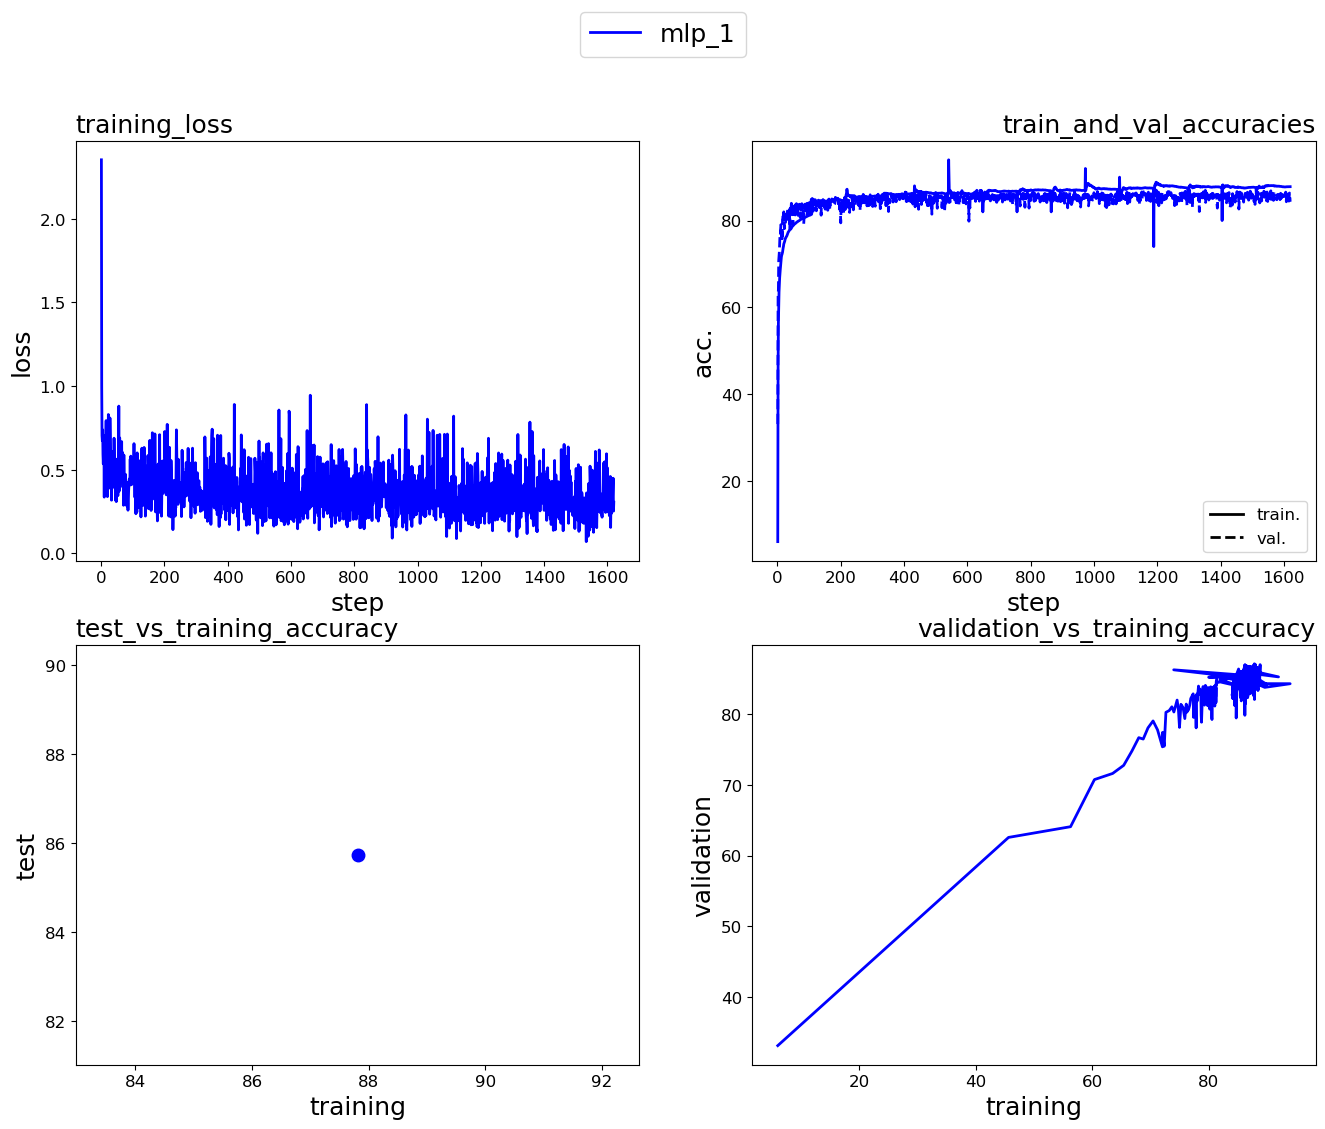

In [240]:
liste = [experiment_results]
ut.part3Plots(liste)

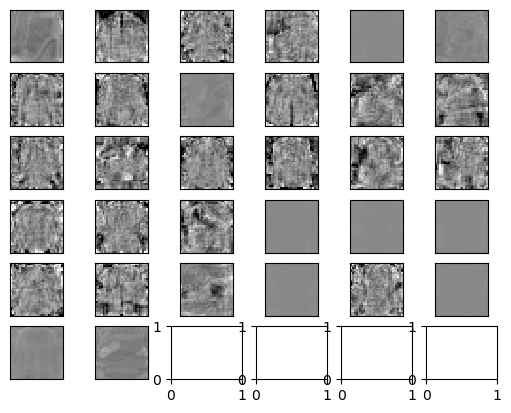

In [245]:
ut.visualizeWeights(first_layer_weights,'/Users/mustafaerdikararmaz/Documents/GitHub/Computational_Intelligence/HW1')